# Titanic Dataset

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.datasets import load_iris
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import ( 
    AdaBoostClassifier, 
    BaggingClassifier, 
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    f1_score, 
    precision_score, 
    recall_score
)




## Data Pre-processing

In [55]:
df=pd.read_csv("titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1310,1,1,"Name1310, Miss. Surname1310",female,NaN,0,0,SOTON/O2 3101272,76.760165,NaN,C
1,1311,0,3,"Name1311, Col. Surname1311",male,29.0,0,0,223596,10.193097,NaN,S
2,1312,0,3,"Name1312, Mr. Surname1312",male,20.0,0,0,54636,12.029416,C83,C
3,1313,0,3,"Name1313, Mr. Surname1313",male,27.0,0,0,PC 17760,13.429448,NaN,S
4,1314,0,3,"Name1314, Mr. Surname1314",male,32.0,0,0,364512,4.840769,E33,C


In [56]:
print(f"Unique values")
for column in df.columns:
    print(f"{column}: {df[column].nunique()}")

Unique values
PassengerId: 1000000
Survived: 2
Pclass: 3
Name: 1000000
Sex: 2
Age: 102
SibSp: 7
Parch: 7
Ticket: 681
Fare: 938264
Cabin: 147
Embarked: 3


The name column is written as "Name + PassengerID, Honorifics Surnmame + PassengerID". Due to PassengerId does not give any information we will drop that and in the name column we will drop everything except the Honorifics. The honorifics might have high correlation with "Sex" column but it gives additional infotmation like "Capt., Col., Major, Dr., etc.".

In [57]:
def clean_name_column(name):
    # Regular expression to match the format "NameXXXX, Prefix. SurnameXXXX"
    match = re.match(r"Name\d+, (.*) Surname\d+", name)
    if match:
        return match.group(1).strip()
    return name 

df['Name'] = df['Name'].apply(clean_name_column)
df = df.drop(columns=['PassengerId', 'Ticket', 'Cabin'])
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,1,Miss.,female,NaN,0,0,76.760165,C
1,0,3,Col.,male,29.0,0,0,10.193097,S
2,0,3,Mr.,male,20.0,0,0,12.029416,C
3,0,3,Mr.,male,27.0,0,0,13.429448,S
4,0,3,Mr.,male,32.0,0,0,4.840769,C


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Survived  1000000 non-null  int64  
 1   Pclass    1000000 non-null  int64  
 2   Name      1000000 non-null  object 
 3   Sex       1000000 non-null  object 
 4   Age       801400 non-null   float64
 5   SibSp     1000000 non-null  int64  
 6   Parch     1000000 non-null  int64  
 7   Fare      1000000 non-null  float64
 8   Embarked  997760 non-null   object 
dtypes: float64(2), int64(4), object(3)
memory usage: 68.7+ MB


We need to identify empty columns in the dataset. For numerical columns, fill the empty values with the column's mean. For non-numerical (object) columns, replace the empty values with "Unknown".

In [59]:
df.isnull().sum()

Survived         0
Pclass           0
Name             0
Sex              0
Age         198600
SibSp            0
Parch            0
Fare             0
Embarked      2240
dtype: int64

In [60]:
df['Age'] = df['Age'].fillna(df['Age'].mean()).astype(int)
name_counts = df['Name'].value_counts()
df.isnull().sum()

Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked    2240
dtype: int64

After filling the missing values, we need to transform the categorical labels into numerical values for better analysis and processing. We'll apply a label encoder and display the data both before and after the transformation.

In [61]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,1,Miss.,female,29,0,0,76.760165,C
1,0,3,Col.,male,29,0,0,10.193097,S
2,0,3,Mr.,male,20,0,0,12.029416,C
3,0,3,Mr.,male,27,0,0,13.429448,S
4,0,3,Mr.,male,32,0,0,4.840769,C


## Graphs and Plots for Better Understanding

### Survived
Indicates whether the passenger survived (1) or did not survive (0). This is a binary outcome used in survival analysis.

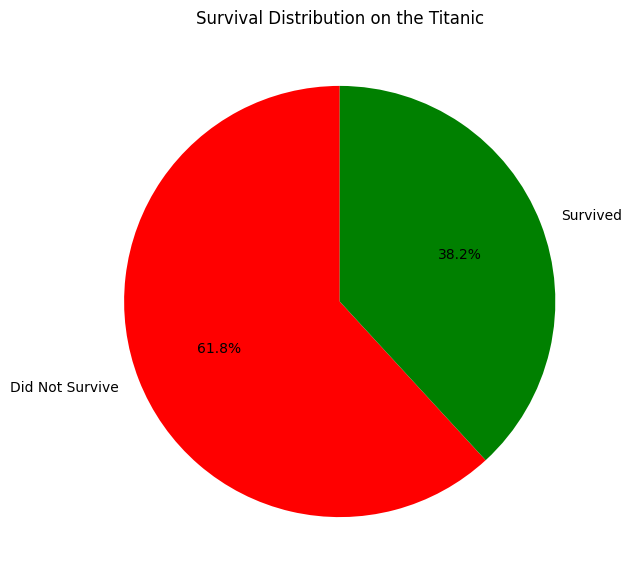

In [62]:
survival_counts = df['Survived'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(survival_counts, labels=['Did Not Survive', 'Survived'], autopct='%1.1f%%', startangle=90, colors=['red', 'green'])
plt.title('Survival Distribution on the Titanic')
plt.show()

### Pclass
The passenger's class on the Titanic. It is an integer value:

1: First class
2: Second class
3: Third class

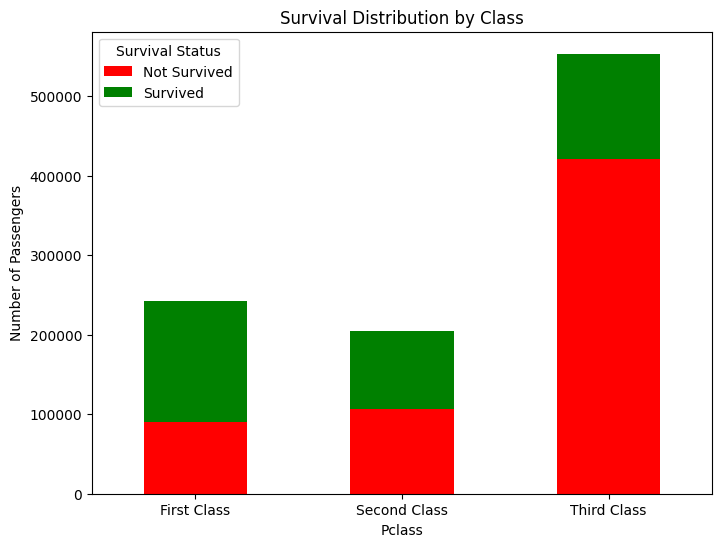

In [63]:
class_mapping = {1: 'First Class', 2: 'Second Class', 3: 'Third Class'}
survival_by_class = pd.crosstab(df['Pclass'], df['Survived'], margins=False, normalize=False)

ax = survival_by_class.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(8, 6))
plt.title('Survival Distribution by Class')
plt.xlabel('Pclass')
plt.ylabel('Number of Passengers')
ax.set_xticklabels(['First Class', 'Second Class', 'Third Class'])
plt.xticks(rotation=0)
plt.legend(['Not Survived', 'Survived'], title='Survival Status')
plt.show()


### Name
The honorifics (e.g., Mr., Miss., Master, etc.) of the passenger.

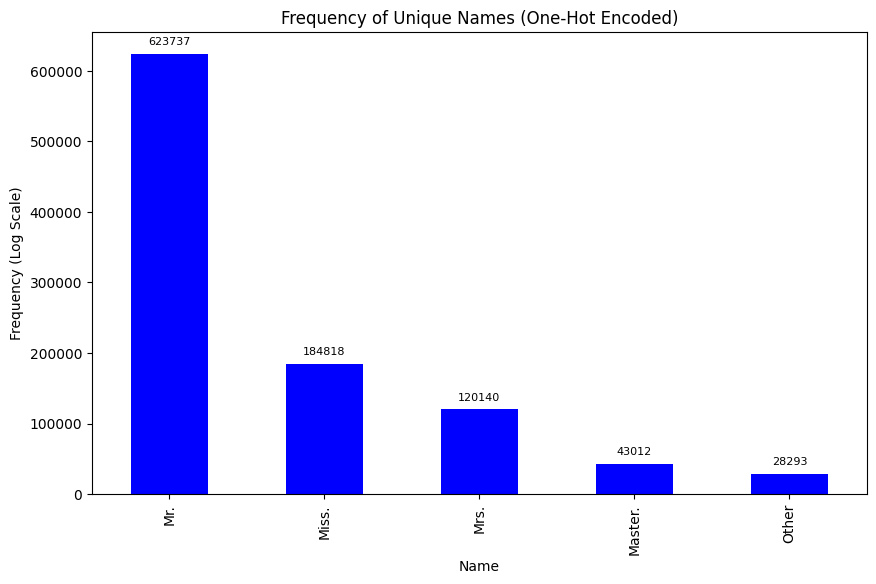

In [64]:
# Define categories for one-hot encoding
categories = ['Mr.', 'Miss.', 'Mrs.', 'Master.']

# Create a one-hot encoded DataFrame
name_counts_one_hot = pd.DataFrame(0, index=['Frequency'], columns=categories + ['Other'])

# Combine counts for defined categories and "Other"
for name, count in name_counts.items():
    if name in categories:
        name_counts_one_hot.at['Frequency', name] += count
    else:
        name_counts_one_hot.at['Frequency', 'Other'] += count

# Convert to a Series for plotting
name_counts_one_hot_series = name_counts_one_hot.loc['Frequency']

# Plotting
plt.figure(figsize=(10, 6))
ax = name_counts_one_hot_series.plot(kind='bar', color='blue')

plt.title('Frequency of Unique Names (One-Hot Encoded)')
plt.xlabel('Name')
plt.ylabel('Frequency (Log Scale)')
plt.xticks(rotation=90)  # Rotate names for better visibility

# Adding value labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Display as integers
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                xytext=(0, 5),  # Move the annotation slightly above
                textcoords='offset points', 
                ha='center', va='bottom', 
                fontsize=8)  # Smaller font size
plt.show()


In [65]:
# Define categories for one-hot encoding
categories = ['Mr.', 'Miss.', 'Mrs.', 'Master.', 'Other']

# Replace non-categorized titles with 'Other'
df['Name'] = df['Name'].fillna('Other')
df['Name'] = df['Name'].apply(lambda x: x if x in categories else 'Other')

# Initialize one-hot encoded columns with zeros
for category in categories:
    df[category] = (df['Name'] == category).astype(int)

df.drop(columns=['Name'], inplace=True)


### Sex
The gender of the passenger. Values are "male" or "female".

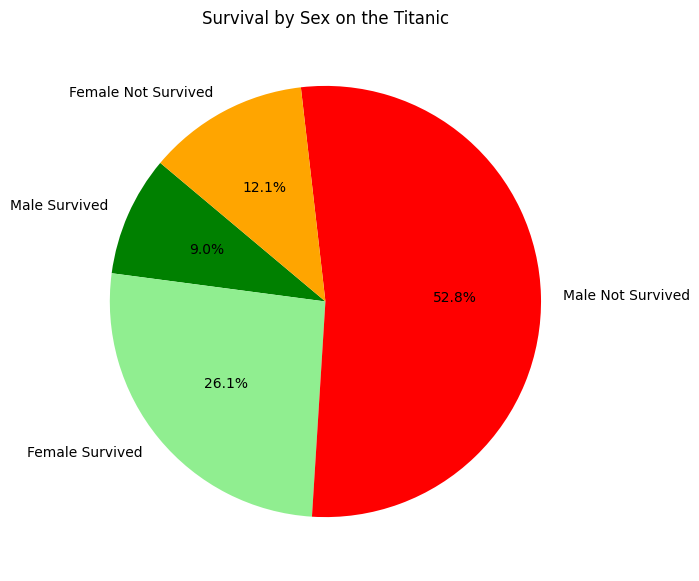

In [66]:
survival_by_sex = df.groupby(['Sex', 'Survived']).size().unstack(fill_value=0)
survival_counts = survival_by_sex.stack()
survival_counts.plot.pie(autopct='%1.1f%%', startangle=140, figsize=(7, 7), labels=['Male Survived', 'Female Survived', 'Male Not Survived', 'Female Not Survived'], colors=['green', 'lightgreen', 'red', 'orange'])
plt.title("Survival by Sex on the Titanic")
plt.ylabel('')
plt.show()


### Age
The age of the passenger. As some entries were missing, the missing values were filled in with the calculated mean.

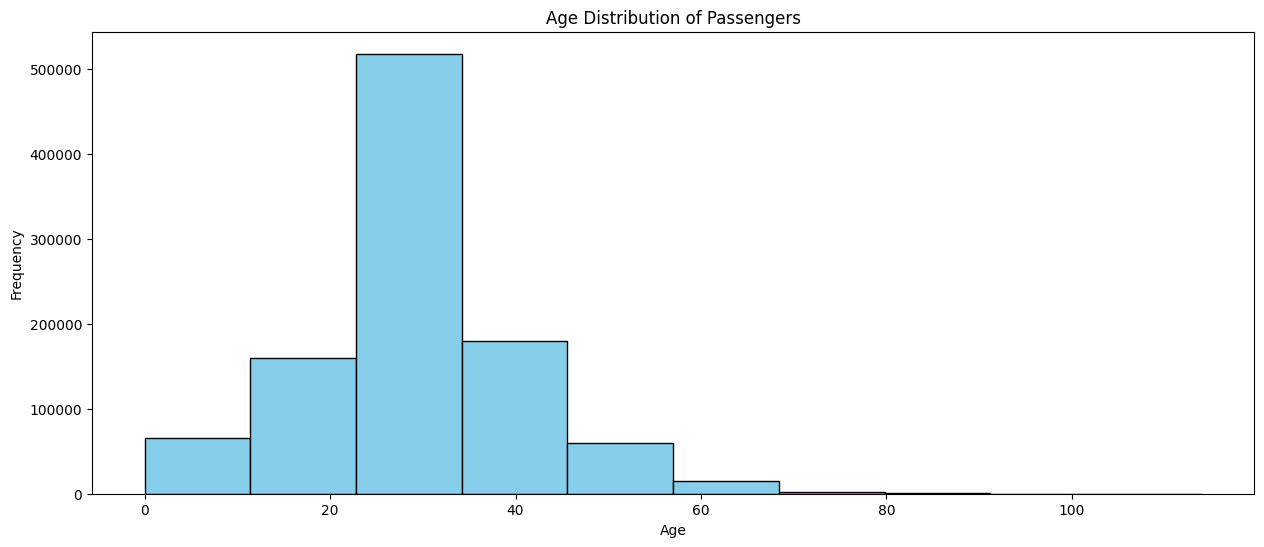

In [67]:
df['Sex'] = df['Sex'].map({'female': 0, 'male': 1})
plt.figure(figsize=(15,6))
df['Age'].plot(kind='hist', bins=10, color='skyblue', edgecolor='black')
plt.title("Age Distribution of Passengers")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

### SibSp
The number of siblings or spouses the passenger had aboard the Titanic.

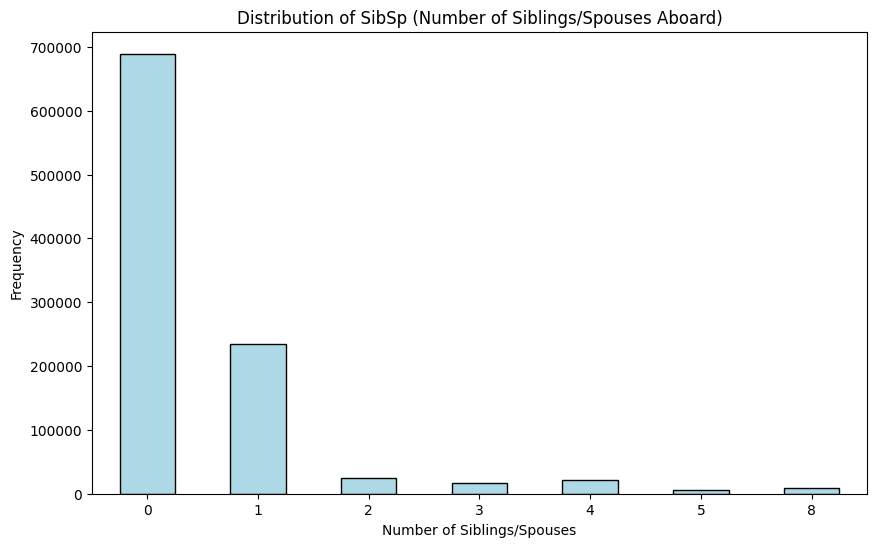

In [68]:
plt.figure(figsize=(10,6))
df['SibSp'].value_counts().sort_index().plot(kind='bar', color='lightblue', edgecolor='black')
plt.title("Distribution of SibSp (Number of Siblings/Spouses Aboard)")
plt.xlabel("Number of Siblings/Spouses")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

### Parch
The number of parents or children the passenger had aboard the Titanic.

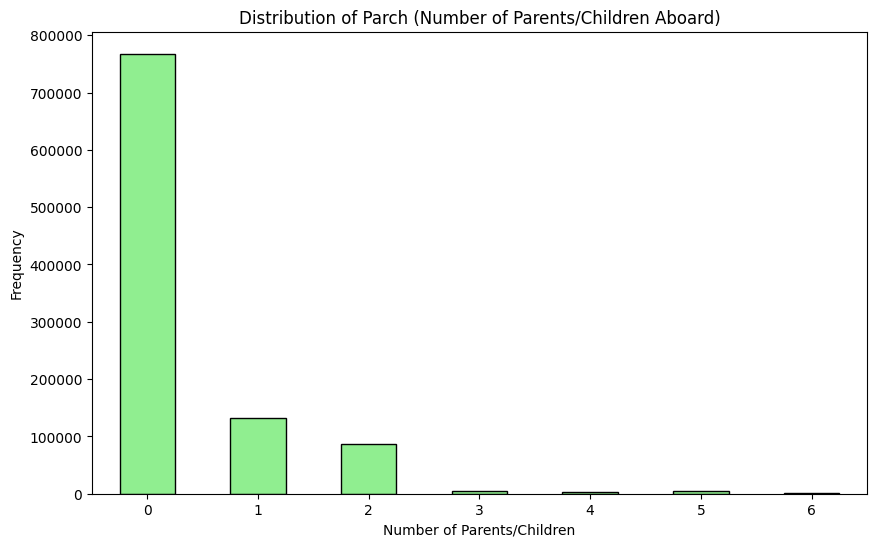

In [69]:
plt.figure(figsize=(10,6))
df['Parch'].value_counts().sort_index().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Distribution of Parch (Number of Parents/Children Aboard)")
plt.xlabel("Number of Parents/Children")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

### Fare
The fare that the passenger paid for the ticket.

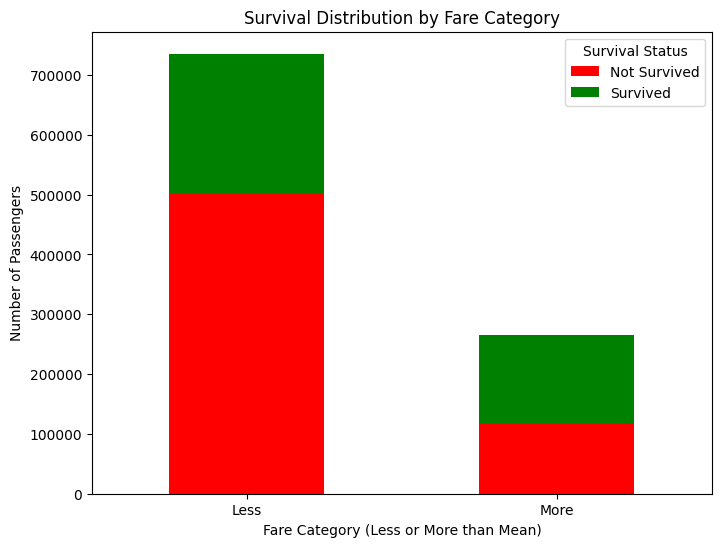

In [70]:
# Calculate the mean fare
mean_fare = df['Fare'].mean()
df['Fare Category'] = df['Fare'].apply(lambda x: 'More' if x > mean_fare else 'Less')
survival_by_fare_category = pd.crosstab(df['Fare Category'], df['Survived'], margins=False)

ax = survival_by_fare_category.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(8, 6))
plt.title('Survival Distribution by Fare Category')
plt.xlabel('Fare Category (Less or More than Mean)')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=0)
plt.legend(['Not Survived', 'Survived'], title='Survival Status')
plt.show()
df = df.drop(columns=['Fare Category'])


### Embarked
The port where the passenger boarded the Titanic. The categorical values turned to binary using one-hot encoding:

"C": Cherbourg

"Q": Queenstown

"S": Southampton

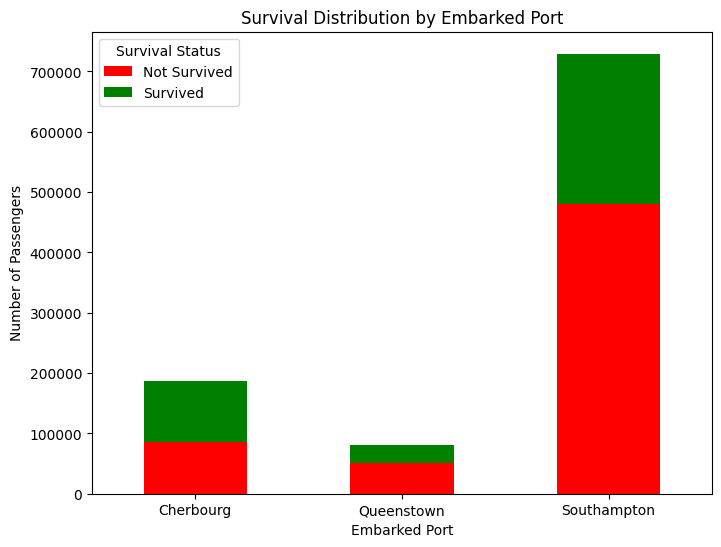

In [71]:
embarked_labels = {'C': 'Cherbourg','Q': 'Queenstown','S': 'Southampton'}
survival_by_embarked = df.groupby(['Embarked', 'Survived']).size().unstack(fill_value=0)
ax = survival_by_embarked.plot(
    kind='bar',
    stacked=True,
    color=['red', 'green'],
    figsize=(8, 6)
)
ax.set_xticklabels([embarked_labels.get(x, x) for x in survival_by_embarked.index], rotation=0)
plt.title('Survival Distribution by Embarked Port')
plt.xlabel('Embarked Port')
plt.ylabel('Number of Passengers')
plt.legend(['Not Survived', 'Survived'], title='Survival Status')
plt.show()


In [72]:
df = pd.get_dummies(df, columns=['Embarked'])  # Drop the first column to avoid multicollinearity
df = df.replace({True: 1, False: 0})
df.head()


C:\Users\User\AppData\Local\Temp\ipykernel_21444\1339330375.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Mr.,Miss.,Mrs.,Master.,Other,Embarked_C,Embarked_Q,Embarked_S
0,1,1,0,29,0,0,76.760165,0,1,0,0,0,1,0,0
1,0,3,1,29,0,0,10.193097,0,0,0,0,1,0,0,1
2,0,3,1,20,0,0,12.029416,1,0,0,0,0,1,0,0
3,0,3,1,27,0,0,13.429448,1,0,0,0,0,0,0,1
4,0,3,1,32,0,0,4.840769,1,0,0,0,0,1,0,0


### Correlation Matrix
A correlation matrix is a table that shows the correlation coefficients between multiple variables. Each cell in the matrix represents the correlation between two variables, ranging from -1 to 1:

+1 indicates a perfect positive correlation (both variables increase together).

-1 indicates a perfect negative correlation (one variable increases while the other decreases).

0 indicates no linear relationship between the variables.

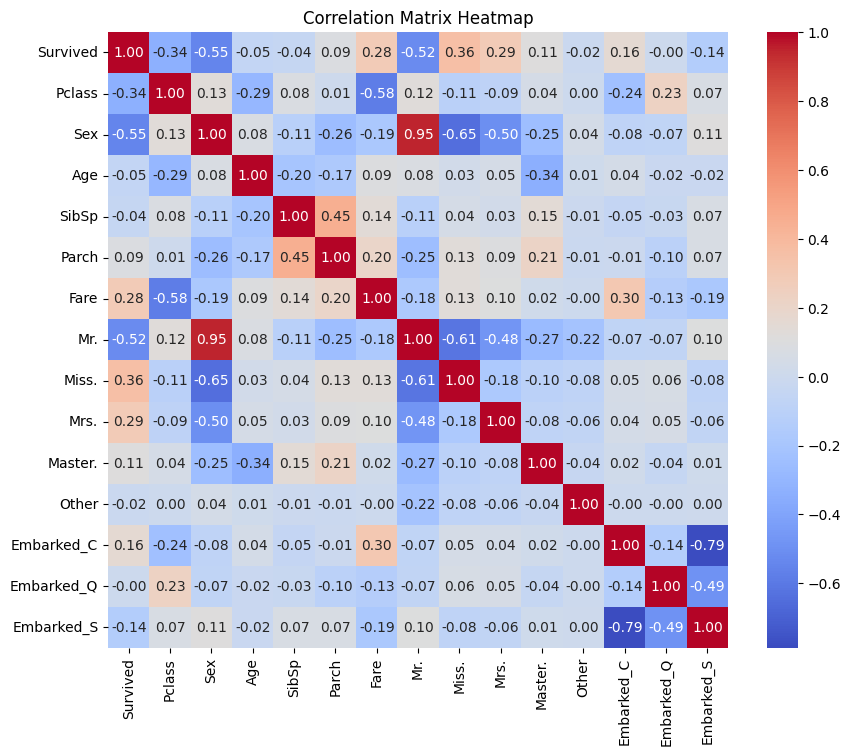

In [73]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()


In [74]:
df.head(15)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Mr.,Miss.,Mrs.,Master.,Other,Embarked_C,Embarked_Q,Embarked_S
0,1,1,0,29,0,0,76.760165,0,1,0,0,0,1,0,0
1,0,3,1,29,0,0,10.193097,0,0,0,0,1,0,0,1
2,0,3,1,20,0,0,12.029416,1,0,0,0,0,1,0,0
3,0,3,1,27,0,0,13.429448,1,0,0,0,0,0,0,1
4,0,3,1,32,0,0,4.840769,1,0,0,0,0,1,0,0
5,1,3,0,0,0,0,14.805817,0,0,0,1,0,0,0,1
6,0,1,1,29,0,0,115.806344,1,0,0,0,0,1,0,0
7,1,2,0,28,0,1,27.950048,0,1,0,0,0,0,0,1
8,0,1,1,29,0,0,29.467203,1,0,0,0,0,0,0,1
9,0,2,1,32,0,0,0.000000,1,0,0,0,0,0,0,1


# Training & Test

## Partition of the Data

In [75]:
X = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Mr.', 'Miss.', 'Mrs.', 'Master.','Other','Embarked_C', 'Embarked_Q', 'Embarked_S']]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.head())
print(y_train.head())
df.shape, X_train.shape, X_test.shape

        Pclass  Sex  Age  SibSp  Parch       Fare  Mr.  Miss.  Mrs.  Master.  \
566853       2    0   29      0      0   7.883266    0      1     0        0   
382311       3    0   25      0      1  16.264782    0      1     0        0   
241519       3    1   29      4      1  33.510023    1      0     0        0   
719220       2    0   34      2      0  19.870252    0      0     1        0   
905718       3    1    8      4      1  35.843483    1      0     0        0   

        Other  Embarked_C  Embarked_Q  Embarked_S  
566853      0           0           0           1  
382311      0           0           0           1  
241519      0           0           1           0  
719220      0           0           0           1  
905718      0           0           0           1  
566853    1
382311    0
241519    0
719220    0
905718    0
Name: Survived, dtype: int64


((1000000, 15), (800000, 14), (200000, 14))

### Gain ratio

In [357]:
# Initialize the base classifier (Decision Tree)
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Fit the model on the training data
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

# Calculate Precision
precision = precision_score(y_test, y_pred)

# Calculate Recall
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Confusion Matrix: \n{cm}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


Confusion Matrix: 
[[107976  15871]
 [ 17296  58857]]
TP: 58857, TN: 107976, FP: 15871, FN: 17296
Accuracy: 0.834165
Precision: 0.7876164222246013, Recall: 0.7728782845061914, F1 Score: 0.7801777559798782


### Gain ratio with cross-validation

In [358]:
n_splits = 5
# KFold Cross-validation
kf = KFold(n_splits, random_state=42, shuffle=True)

# Initialize the base classifier (Decision Tree)
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)


kf_accuracies = []
kf_f1_scores = []
kf_precisions = []
kf_recalls = []
kf_confusion_matrices = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train), start=1):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    clf.fit(X_train_fold, y_train_fold)
    y_pred = clf.predict(X_val_fold)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val_fold, y_pred)
    kf_accuracies.append(accuracy)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_val_fold, y_pred)
    kf_confusion_matrices.append(cm)
    
    # Extract TP, TN, FP, FN
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    
    # Calculate F1 score
    f1 = f1_score(y_val_fold, y_pred)
    kf_f1_scores.append(f1)
    
    # Calculate Precision
    precision = precision_score(y_val_fold, y_pred)
    kf_precisions.append(precision)
    
    # Calculate Recall
    recall = recall_score(y_val_fold, y_pred)
    kf_recalls.append(recall)
    
    print(f"Fold {fold}:")
    print(f"Confusion Matrix: \n{cm}")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n")

# Print the average of all accuracies, F1 scores, Precision, and Recall
average_accuracy = sum(kf_accuracies) / n_splits
average_f1_score = sum(kf_f1_scores) / n_splits
average_precision = sum(kf_precisions) / n_splits
average_recall = sum(kf_recalls) / n_splits

print(f"\nAverage accuracy: {average_accuracy}")
print(f"Average F1 score: {average_f1_score}")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")

Fold 1:
Confusion Matrix: 
[[85836 12982]
 [13790 47392]]
TP: 47392, TN: 85836, FP: 12982, FN: 13790
Accuracy: 0.832675
Precision: 0.7849736641600689, Recall: 0.7746069105292406, F1 Score: 0.7797558327026226

Fold 2:
Confusion Matrix: 
[[85894 12891]
 [13789 47426]]
TP: 47426, TN: 85894, FP: 12891, FN: 13789
Accuracy: 0.83325
Precision: 0.7862791584462092, Recall: 0.7747447521032427, F1 Score: 0.7804693414080243

Fold 3:
Confusion Matrix: 
[[86155 12951]
 [13706 47188]]
TP: 47188, TN: 86155, FP: 12951, FN: 13706
Accuracy: 0.83339375
Precision: 0.7846488967225926, Recall: 0.7749203534009919, F1 Score: 0.779754281890063

Fold 4:
Confusion Matrix: 
[[86211 12684]
 [13956 47149]]
TP: 47149, TN: 86211, FP: 12684, FN: 13956
Accuracy: 0.8335
Precision: 0.7880099610582789, Recall: 0.7716062515342443, F1 Score: 0.7797218409432932

Fold 5:
Confusion Matrix: 
[[86257 12611]
 [14094 47038]]
TP: 47038, TN: 86257, FP: 12611, FN: 14094
Accuracy: 0.83309375
Precision: 0.7885798588408859, Recall: 0.769

### Gain ratio with bagging

In [359]:
# Initialize the base classifier (Decision Tree)
base_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)

clf = BaggingClassifier(estimator=base_clf, n_estimators=5, random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]
# Calculate F1 score
f1 = f1_score(y_test, y_pred)

# Calculate Precision
precision = precision_score(y_test, y_pred)

# Calculate Recall
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Confusion Matrix: \n{cm}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


Confusion Matrix: 
[[110667  13180]
 [ 16535  59618]]
TP: 59618, TN: 110667, FP: 13180, FN: 16535
Accuracy: 0.851425
Precision: 0.818951070084343, Recall: 0.7828713248329022, F1 Score: 0.800504864015683


### Gain ratio with boosting

In [360]:
# Initialize the base classifier (Decision Tree)
base_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)

clf = AdaBoostClassifier(estimator=base_clf, n_estimators=5, algorithm='SAMME', random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

# Calculate Precision
precision = precision_score(y_test, y_pred)

# Calculate Recall
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Confusion Matrix: \n{cm}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


Confusion Matrix: 
[[107798  16049]
 [ 17066  59087]]
TP: 59087, TN: 107798, FP: 16049, FN: 17066
Accuracy: 0.834425
Precision: 0.7864006601362862, Recall: 0.7758985200845666, F1 Score: 0.7811142911910317


### Gain ratio with cross-validation, bagging and boosting

In [361]:
n_splits = 5
# KFold Cross-validation
kf = KFold(n_splits, random_state=42, shuffle=True)

# Initialize the base classifier (Decision Tree)
base_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Initialize the Bagging classifier
bag_clf = BaggingClassifier(estimator=base_clf, n_estimators=5, random_state=42)

# Initialize the AdaBoost classifier with SAMME algorithm to avoid deprecation warning
clf = AdaBoostClassifier(estimator=bag_clf, n_estimators=5, algorithm='SAMME', random_state=42)

kf_accuracies = []
kf_f1_scores = []
kf_precisions = []
kf_recalls = []
kf_confusion_matrices = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train), start=1):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    clf.fit(X_train_fold, y_train_fold)
    y_pred = clf.predict(X_val_fold)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val_fold, y_pred)
    kf_accuracies.append(accuracy)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_val_fold, y_pred)
    kf_confusion_matrices.append(cm)
    
    # Extract TP, TN, FP, FN
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    
    # Calculate F1 score
    f1 = f1_score(y_val_fold, y_pred)
    kf_f1_scores.append(f1)
    
    # Calculate Precision
    precision = precision_score(y_val_fold, y_pred)
    kf_precisions.append(precision)
    
    # Calculate Recall
    recall = recall_score(y_val_fold, y_pred)
    kf_recalls.append(recall)
    
    print(f"Fold {fold}:")
    print(f"Confusion Matrix: \n{cm}")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n")

# Print the average of all accuracies, F1 scores, Precision, and Recall
average_accuracy = sum(kf_accuracies) / n_splits
average_f1_score = sum(kf_f1_scores) / n_splits
average_precision = sum(kf_precisions) / n_splits
average_recall = sum(kf_recalls) / n_splits

print(f"\nAverage accuracy: {average_accuracy}")
print(f"Average F1 score: {average_f1_score}")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")

Fold 1:
Confusion Matrix: 
[[87188 11630]
 [12139 49043]]
TP: 49043, TN: 87188, FP: 11630, FN: 12139
Accuracy: 0.85144375
Precision: 0.808316714189178, Recall: 0.8015919714948841, F1 Score: 0.8049402978950392

Fold 2:
Confusion Matrix: 
[[87447 11338]
 [12274 48941]]
TP: 48941, TN: 87447, FP: 11338, FN: 12274
Accuracy: 0.852425
Precision: 0.8119079613132268, Recall: 0.7994935881728334, F1 Score: 0.8056529540553443

Fold 3:
Confusion Matrix: 
[[87605 11501]
 [12256 48638]]
TP: 48638, TN: 87605, FP: 11501, FN: 12256
Accuracy: 0.85151875
Precision: 0.8087597066795258, Recall: 0.798732223207541, F1 Score: 0.8037146893822346

Fold 4:
Confusion Matrix: 
[[87774 11121]
 [12406 48699]]
TP: 48699, TN: 87774, FP: 11121, FN: 12406
Accuracy: 0.85295625
Precision: 0.8140922768304915, Recall: 0.7969724245151788, F1 Score: 0.8054413892908828

Fold 5:
Confusion Matrix: 
[[87629 11239]
 [12436 48696]]
TP: 48696, TN: 87629, FP: 11239, FN: 12436
Accuracy: 0.85203125
Precision: 0.8124801868691082, Recall:

### Gini index

In [364]:
#Gini
clf = DecisionTreeClassifier(criterion='gini', random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{cm}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


Accuracy: 0.833765
Confusion Matrix: 
[[107868  15979]
 [ 17268  58885]]
TP: 58885, TN: 107868, FP: 15979, FN: 17268
Precision: 0.7865596281256679, Recall: 0.7732459653592111, F1 Score: 0.7798459776051703


### Gini index with bagging

In [365]:
#Gini
base_clf = DecisionTreeClassifier(criterion='gini', random_state=42)

#Boosting
clf = BaggingClassifier(estimator=base_clf, n_estimators=5, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{cm}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


Accuracy: 0.85049
Confusion Matrix: 
[[110525  13322]
 [ 16580  59573]]
TP: 59573, TN: 110525, FP: 13322, FN: 16580
Precision: 0.8172439810686604, Recall: 0.7822804091762636, F1 Score: 0.7993800654822607


### Gini index with boosting

In [366]:
#Gini
base_clf = DecisionTreeClassifier(criterion='gini', random_state=42)

#Boosting
clf = AdaBoostClassifier(estimator=base_clf, n_estimators=5, algorithm='SAMME', random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{cm}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


Accuracy: 0.83481
Confusion Matrix: 
[[107788  16059]
 [ 16979  59174]]
TP: 59174, TN: 107788, FP: 16059, FN: 16979
Precision: 0.7865431393138649, Recall: 0.7770409570207346, F1 Score: 0.7817631749303106


### Naive Bayes

In [ ]:
# Standardize the data
scaler = Normalizer()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = X_train_scaled
X_test = X_test_scaled

# Naive Bayes classifier
clf = GaussianNB()

clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{cm}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


Accuracy: 0.780725
Confusion Matrix: 
[[99955 23892]
 [19963 56190]]
TP: 56190, TN: 99955, FP: 23892, FN: 19963
Precision: 0.7016558028021278, Recall: 0.7378566832560766, F1 Score: 0.7193010529010785


### Naive Bayes with bagging

In [94]:
#NaiveBayes
base_clf = GaussianNB()

clf = BaggingClassifier(estimator=base_clf, n_estimators=50, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{cm}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

Accuracy: 0.780705
Confusion Matrix: 
[[99953 23894]
 [19965 56188]]
TP: 56188, TN: 99953, FP: 23894, FN: 19965
Precision: 0.7016308284008891, Recall: 0.7378304203380037, F1 Score: 0.7192754504432426


### Naive Bayes with boosting

In [79]:
#NaiveBayes
base_clf = GaussianNB()

clf = AdaBoostClassifier(estimator=base_clf, n_estimators=50, algorithm='SAMME', random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{cm}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

Accuracy: 0.787865
Confusion Matrix: 
[[103404  20443]
 [ 21984  54169]]
TP: 54169, TN: 103404, FP: 20443, FN: 21984
Precision: 0.7260092210368305, Recall: 0.7113180045434848, F1 Score: 0.718588531821046


### ANN

In [ ]:

# Define the MLP model
mlp_clf = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', 
                         learning_rate_init=0.001, max_iter=200, random_state=42)

# Train the bagging classifier
mlp_clf.fit(X_train, y_train)

# Predict
y_pred = mlp_clf.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1] if cm.shape[0] > 1 else 0
tn = cm[0, 0]
fp = cm[0, 1] if cm.shape[1] > 1 else 0
fn = cm[1, 0] if cm.shape[0] > 1 else 0

f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{cm}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Accuracy: 0.85952
Confusion Matrix: 
[[113435  10412]
 [ 17684  58469]]
TP: 58469, TN: 113435, FP: 10412, FN: 17684
Precision: 0.8589277176121908, Recall: 0.85952, F1 Score: 0.8580015153475664


### ANN with bagging

In [47]:

# Define the MLP model
mlp_clf = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', 
                         learning_rate_init=0.001, max_iter=200, random_state=42)

# Implement bagging with the MLP model
bagging_clf = BaggingClassifier(estimator=mlp_clf, n_estimators=5, random_state=42)

# Train the bagging classifier
bagging_clf.fit(X_train, y_train)

# Predict
y_pred = bagging_clf.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1] if cm.shape[0] > 1 else 0
tn = cm[0, 0]
fp = cm[0, 1] if cm.shape[1] > 1 else 0
fn = cm[1, 0] if cm.shape[0] > 1 else 0

f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{cm}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

Accuracy: 0.85865
Confusion Matrix: 
[[115920   7927]
 [ 20343  55810]]
TP: 55810, TN: 115920, FP: 7927, FN: 20343
Precision: 0.8601971402390752, Recall: 0.85865, F1 Score: 0.8557507843158368


### ANN with boosting

In [ ]:
class customMLPClassifer(MLPClassifier):
    def resample_with_replacement(self, X_train, y_train, sample_weight):

        # normalize sample_weights if not already
        sample_weight = sample_weight / sample_weight.sum(dtype=np.float64)

        X_train_resampled = np.zeros((len(X_train), len(X_train[0])), dtype=np.float32)
        y_train_resampled = np.zeros((len(y_train)), dtype=int)
        for i in range(len(X_train)):
            # draw a number from 0 to len(X_train)-1
            draw = np.random.choice(np.arange(len(X_train)), p=sample_weight)

            # place the X and y at the drawn number into the resampled X and y
            X_train_resampled[i] = X_train[draw]
            y_train_resampled[i] = y_train[draw]

        return X_train_resampled, y_train_resampled


    def fit(self, X, y, sample_weight=None):
        if sample_weight is not None:
            X, y = self.resample_with_replacement(X, y, sample_weight)
        
        return self._fit(X, y, incremental=(self.warm_start and
                                            hasattr(self, "classes_")))


X, y = load_iris(return_X_y=True)
adabooster = AdaBoostClassifier(estimator=customMLPClassifer())

adabooster.fit(X_train, y_train)

# Predict
y_pred = adabooster.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


KeyboardInterrupt: 

### Two layer ANN

In [52]:

# Define the MLP model
clf = MLPClassifier(hidden_layer_sizes=(10,5), activation='relu', solver='adam', 
                         learning_rate_init=0.001, max_iter=200, random_state=42)

clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1] if cm.shape[0] > 1 else 0
tn = cm[0, 0]
fp = cm[0, 1] if cm.shape[1] > 1 else 0
fn = cm[1, 0] if cm.shape[0] > 1 else 0

f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{cm}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

Accuracy: 0.861285
Confusion Matrix: 
[[115095   8752]
 [ 18991  57162]]
TP: 57162, TN: 115095, FP: 8752, FN: 18991
Precision: 0.8617382757203448, Recall: 0.861285, F1 Score: 0.859039532008424


### Two Layer ANN with bagging

In [51]:

# Define the MLP model
mlp_clf = MLPClassifier(hidden_layer_sizes=(10,5 ), activation='relu', solver='adam', 
                         learning_rate_init=0.001, max_iter=200, random_state=42)

# Implement bagging with the MLP model
bagging_clf = BaggingClassifier(estimator=mlp_clf, n_estimators=5, random_state=42)

# Train the bagging classifier
bagging_clf.fit(X_train, y_train)

# Predict
y_pred = bagging_clf.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1] if cm.shape[0] > 1 else 0
tn = cm[0, 0]
fp = cm[0, 1] if cm.shape[1] > 1 else 0
fn = cm[1, 0] if cm.shape[0] > 1 else 0

f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{cm}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

Accuracy: 0.86801
Confusion Matrix: 
[[115698   8149]
 [ 18249  57904]]
TP: 57904, TN: 115698, FP: 8149, FN: 18249
Precision: 0.8686599262481282, Recall: 0.86801, F1 Score: 0.8659083788500002


### Two Layer ANN with boosting

In [85]:
class customMLPClassifer(MLPClassifier):
    def resample_with_replacement(self, X_train, y_train, sample_weight):
        # normalize sample_weights if not already
        sample_weight = sample_weight / sample_weight.sum(dtype=np.float64)

        X_train_resampled = np.zeros((len(X_train), len(X_train[0])), dtype=np.float32)
        y_train_resampled = np.zeros((len(y_train)), dtype=int)
        for i in range(len(X_train)):
            # draw a number from 0 to len(X_train)-1
            draw = np.random.choice(np.arange(len(X_train)), p=sample_weight)

            # place the X and y at the drawn number into the resampled X and y
            X_train_resampled[i] = X_train[draw]
            y_train_resampled[i] = y_train[draw]

        return X_train_resampled, y_train_resampled

    def fit(self, X, y, sample_weight=None):
        if sample_weight is not None:
            X, y = self.resample_with_replacement(X, y, sample_weight)
        
        return self._fit(X, y, incremental=(self.warm_start and
                                            hasattr(self, "classes_")))

# Load data
X, y = load_iris(return_X_y=True)

# Specify custom MLP classifier with 2 hidden layers
adabooster = AdaBoostClassifier(
    estimator=customMLPClassifer(hidden_layer_sizes=(10, 10))
)


# Fit
adabooster.fit(X_train, y_train)

# Predict
y_pred = adabooster.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:

# Define the MLP model
mlp_clf = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', 
                         learning_rate_init=0.001, max_iter=200, random_state=42)

# Implement bagging with the MLP model
bagging_clf = BaggingClassifier(estimator=mlp_clf, n_estimators=5, random_state=42)

# Train the bagging classifier
bagging_clf.fit(X_train, y_train)

# Predict
y_pred = bagging_clf.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1] if cm.shape[0] > 1 else 0
tn = cm[0, 0]
fp = cm[0, 1] if cm.shape[1] > 1 else 0
fn = cm[1, 0] if cm.shape[0] > 1 else 0

f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{cm}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.84987
Confusion Matrix: 
[[115997   7850]
 [ 22176  53977]]
TP: 115997, TN: 53977, FP: 7850, FN: 22176
Precision: 0.8522715583489565, Recall: 0.84987, F1 Score: 0.8461804482140765


### Support vector machine

In [ ]:
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, test_size=0.875, random_state=42)

# SVM Classifier
clf = SVC(random_state=42)

# Train the classifier on the reduced dataset
clf.fit(X_train_small, y_train_small)

# Predictions on the test set
y_pred = clf.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{cm}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

### Support vector machine with bagging

In [ ]:
# SVM Classifier
base_clf = SVC(random_state=42)

clf = BaggingClassifier(estimator=base_clf, n_estimators=5, random_state=42)

# Train the classifier on the reduced dataset
clf.fit(X_train_small, y_train_small)

# Predictions on the test set
y_pred = clf.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{cm}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

### Support vector machine with boosting

In [ ]:
# SVM Classifier
base_clf = SVC(random_state=42)

clf = AdaBoostClassifier(estimator=base_clf, n_estimators=5, algorithm='SAMME', random_state=42)

# Train the classifier on the reduced dataset
clf.fit(X_train_small, y_train_small)

# Predictions on the test set
y_pred = clf.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{cm}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")